In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
from plotly import figure_factory as ff, graph_objects as go
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)


def metrics(y_true, y_pred_class, y_pred):
    ac = accuracy_score(y_true, y_pred)
    ll = log_loss(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    ps = precision_score(y_true, y_pred)
    mc = confusion_matrix(y_true, y_pred)
    rc = recall_score(y_true, y_pred)

    header = ["Metric", "Accuracy", "Loss(log)", "F1", "Precision", "Recall"]
    score = [
        "Score",
        round(ac, 3),
        round(ll, 3),
        round(f1, 3),
        round(ps, 3),
        round(rc, 3),
    ]

    x = ["Real 0", "Real 1"]
    y = ["Predict 0", "Predict 1"]

    fig = ff.create_table([header, score], height_constant=20)
    fig.show()

    fig = ff.create_annotated_heatmap(z=mc, x=x, y=y, colorscale="Blues")
    fig.show()


<IPython.core.display.Javascript object>

# The Data

## Summary
To explain the labels and counts of the dataset (metadata)

In [4]:
DATASET_DIR = "data/data_image.csv"

<IPython.core.display.Javascript object>

In [5]:
dataset = pd.read_csv(DATASET_DIR)

<IPython.core.display.Javascript object>

## The information about the dataset

# Load the data

In [51]:
%%time
IMG_FORMAT = (224, 224, 1)

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_FORMAT[:2])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, IMG_FORMAT)

    return img


def compose_dataset(df):
    data = []
    labels = []
    
    for full_path, flag in df.sample(frac = 1).values:
        data.append(process_data(full_path))
        labels.append(flag)

    return np.array(data), np.array(labels)


# Creating dataset
train_set = dataset[dataset.kind == "train"][["full_path", "flag"]]
test_set = dataset[dataset.kind == "test"][["full_path", "flag"]]
val_set = dataset[dataset.kind == "val"][["full_path", "flag"]]

# Creating X and y variables
X_train, y_train = compose_dataset(train_set)
X_test, y_test = compose_dataset(test_set)
X_val, y_val = compose_dataset(val_set)

# Infortmations
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)
Wall time: 1min 18s


<IPython.core.display.Javascript object>

In [54]:
# # define generator
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=False,
    vertical_flip=False,
)

# fit generator on our train features
datagen.fit(X_train)

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)

<IPython.core.display.Javascript object>

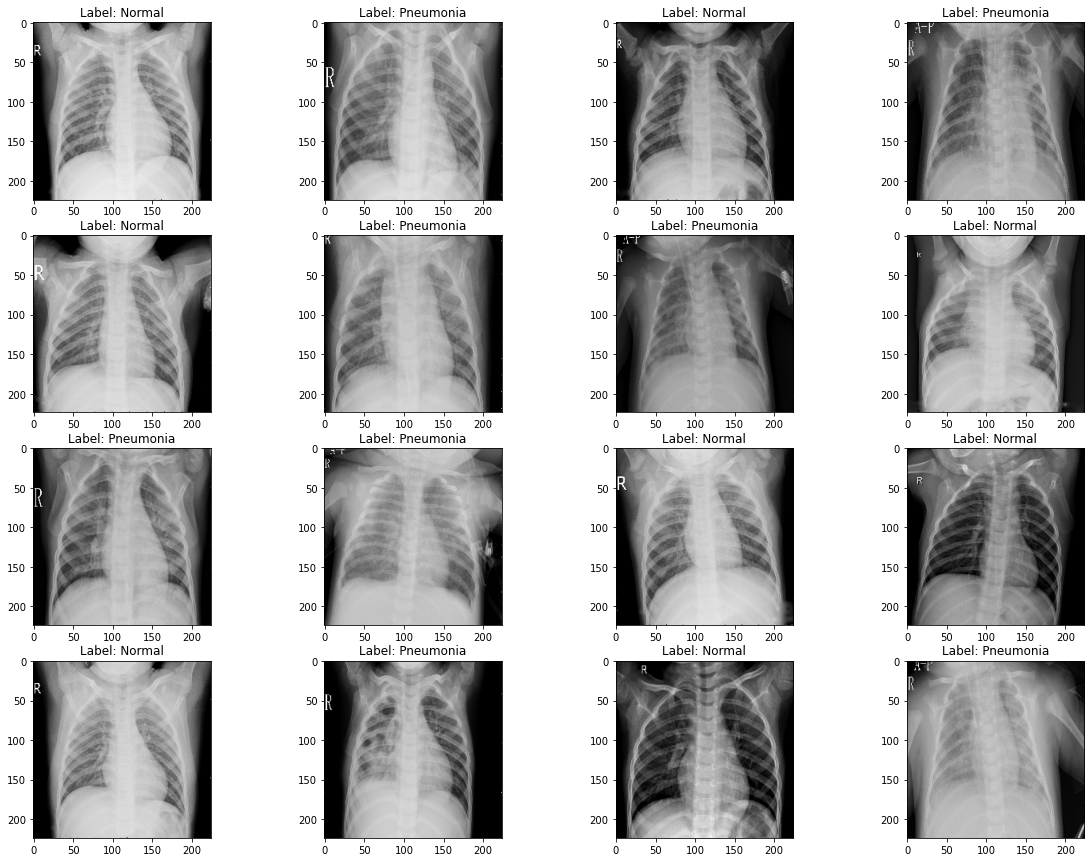

<IPython.core.display.Javascript object>

In [55]:
labels = ["Pneumonia" if y else "Normal" for y in y_val]
plt.figure(figsize=(20, 15))
for i, x in enumerate(X_val):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x.reshape(IMG_FORMAT[:2]), cmap="gray")
    plt.axis("on")
    plt.title("Label: {}".format(labels[i]))

In [60]:
model = Sequential()

model.add(
    Conv2D(
        filters=10,
        kernel_size=(7, 7),
        padding="same",
        activation="relu",
        input_shape=IMG_FORMAT,
    )
)
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(filters=30, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=40, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=50, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=60, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(50, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adamax", metrics=["accuracy"])

callback = EarlyStopping(monitor="loss", patience=5)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    validation_data=(X_test, y_test),
    epochs=100,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/100
1044/1044 [==============================] - 22s 20ms/step - loss: 0.5618 - accuracy: 0.7449 - val_loss: 0.4492 - val_accuracy: 0.7853
Epoch 2/100
1044/1044 [==============================] - 19s 18ms/step - loss: 0.3453 - accuracy: 0.8351 - val_loss: 0.7124 - val_accuracy: 0.6619
Epoch 3/100
1044/1044 [==============================] - 19s 18ms/step - loss: 0.3257 - accuracy: 0.8526 - val_loss: 0.4725 - val_accuracy: 0.7821
Epoch 4/100
1044/1044 [==============================] - 19s 18ms/step - loss: 0.2965 - accuracy: 0.8710 - val_loss: 0.5949 - val_accuracy: 0.7436
Epoch 5/100
1044/1044 [==============================] - 19s 18ms/step - loss: 0.2914 - accuracy: 0.8742 - val_loss: 0.6564 - val_accuracy: 0.7276
Epoch 6/100
1044/1044 [==============================] - 20s 19ms/step - loss: 0.2821 - accuracy: 0.8831 - val_loss: 0.4015 - val_accuracy: 0.8446
Epoch 7/100
1044/1044 [==============================] - 20s 19ms/step - loss: 0.2657 - accuracy: 0.8902 - val_loss: 0

<IPython.core.display.Javascript object>

In [61]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.arange(len(history.history["accuracy"])),
        y=history.history["accuracy"],
        text=np.arange(len(history.history["accuracy"])),
        mode="lines",
        name="accuracy",
    )
)
fig.add_trace(
    go.Scatter(
        x=np.arange(len(history.history["val_accuracy"])),
        text=np.arange(len(history.history["val_accuracy"])),
        y=history.history["val_accuracy"],
        mode="lines",
        name="val_accuracy",
    )
)
fig.update_layout(title="Training", xaxis_title="Epochs", yaxis_title="Accuracy")
fig.show()

<IPython.core.display.Javascript object>

In [67]:
model.save("models\cnn6_ann3_pow10_adamax\model")

INFO:tensorflow:Assets written to: models\cnn6_ann3_pow10_adamax\model\assets


<IPython.core.display.Javascript object>

In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 10)      500       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 10)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 74, 74, 20)        5020      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 20)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 30)        5430      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 40)       

<IPython.core.display.Javascript object>

In [59]:
y_pred = model.predict(X_test, batch_size=4)
y_pred_class = y_pred.round()

metrics(
    y_test,
    y_pred.reshape(1, -1)[0],
    y_pred_class.reshape(1, -1)[0].astype(int),
)

<IPython.core.display.Javascript object>

# XAI

In [37]:
labels = ["Pneumonia" if y else "Normal" for y in y_val]
labels = pd.DataFrame(labels, columns=["Labels"])
predictions = model.predict(X_val).round().reshape(-1, 1).astype(int)
labels["Predictions"] = ["Pneumonia" if y else "Normal" for y in predictions]
labels["Print Real - Predicted"] = labels["Labels"].str.cat(
    labels["Predictions"], sep=" - "
)
labels

,Labels,Predictions,Print Real - Predicted
0,Pneumonia,Pneumonia,Pneumonia - Pneumonia
1,Pneumonia,Pneumonia,Pneumonia - Pneumonia
2,Pneumonia,Pneumonia,Pneumonia - Pneumonia
3,Normal,Normal,Normal - Normal
4,Normal,Normal,Normal - Normal
5,Pneumonia,Pneumonia,Pneumonia - Pneumonia
6,Normal,Normal,Normal - Normal
7,Normal,Normal,Normal - Normal
8,Normal,Pneumonia,Normal - Pneumonia
9,Normal,Pneumonia,Normal - Pneumonia


<IPython.core.display.Javascript object>

In [39]:
labels_to_print = labels["Print Real - Predicted"].values.reshape(-1, 1)

<IPython.core.display.Javascript object>

In [12]:
import shap
import numpy as np

e = shap.DeepExplainer(model, X_val)

shap_values = e.shap_values(X_val)

<IPython.core.display.Javascript object>

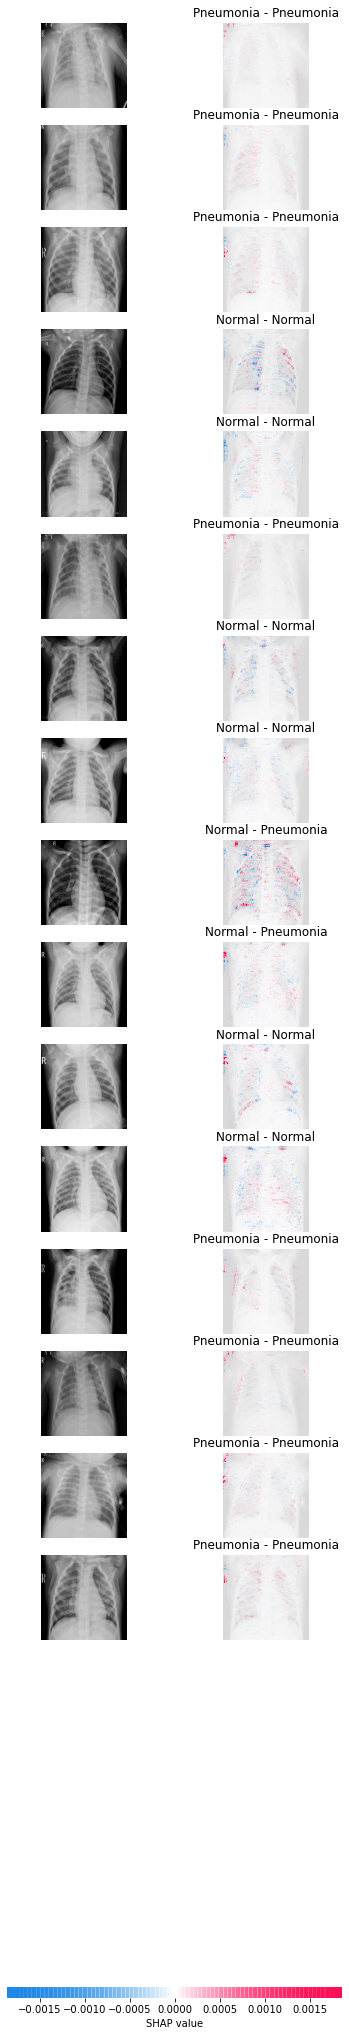

<IPython.core.display.Javascript object>

In [40]:
shap.image_plot(shap_values, X_val, labels_to_print)